# Causal and Predictive Market Views and Stress-Testing
This example is the accompanied code to the Causal and Predictive Market Views and Stress-Testing article, available on ..

It uses the historical risk factor and P&L simulation from the 7_RiskFactorViews.ipynb example. To see how this simulation is generated, see that example.

In [14]:
import numpy as np
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from itertools import product

In [15]:
risk_factors = ft.load_risk_factors()
R = risk_factors.values

# Defining the Bayesian network
The section below specifies a simple Bayesian network allowing us to compute the posterior probabilities for the leaf nodes by hand.

The network has one root node "central bank" with states dovish, expected, hawkish.

The two leaf nodes are "short rate" and "implied vol" with states down, expected, up.

In [16]:
# Specify Bayesian net probability tables
central_bank_prob = np.array([0.25, 0.5, 0.25])
rate_prob = np.array([[0.5, 0.5, 0],
                      [0.25, 0.5, 0.25],
                      [0, 0.5, 0.5]])
vol_prob = np.array([[0.5, 0.5, 0],
                     [0.25, 0.5, 0.25],
                     [0, 0.5, 0.5]])

# Base
rate_prob_base = central_bank_prob @ rate_prob
vol_prob_base = central_bank_prob @ vol_prob

# Dovish
rate_prob_dove = np.array([1, 0, 0]) @ rate_prob
vol_prob_dove = np.array([1, 0, 0]) @ vol_prob

# Hawkish
rate_prob_hawk = np.array([0, 0, 1]) @ rate_prob
vol_prob_hawk = np.array([0, 0, 1]) @ vol_prob

# Specifying the Entropy Pooling views
After defining the Bayesian network, we need to link the discrete states to the continuous risk factor and P&L simulation.

We again do this in a simple way to keep the focus on the steps of the framework, while there is full flexibility in practice.

We assume that the down, expected, and up states for short rate and implied vol correspond to mean - standard deviation, mean, mean + standard deviation.

In [17]:
# Specify Entropy Pooling LHS
S = R.shape[0]
A = np.ones((1, S))  # Probabilities sum to one
rate_1m = R[:, 0][np.newaxis]  # 1m zero-coupon rate
A = np.vstack((A, rate_1m))
vol_index2 = int(np.where(risk_factors.columns == '1m100')[0] - 1)
vol_1m = R[:, vol_index2]
A = np.vstack((A, vol_1m))

In [18]:
# Specify Entropy Pooling RHS values
rate_mean = np.mean(rate_1m)
rate_std = np.std(rate_1m)
rate_values = np.array([rate_mean - rate_std, rate_mean, rate_mean + rate_std])
vol_mean = np.mean(vol_1m)
vol_std = np.std(vol_1m)
vol_values = np.array([vol_mean - vol_std, vol_mean, vol_mean + vol_std])

In [19]:
# Function for computing the causal and predictive posterior
prior = np.ones((S, 1)) / S
def compute_posterior(p1, p2, v1, v2):
    num_joint_probs = len(p1) * len(p2)
    p_js = np.full((num_joint_probs,), np.nan)
    for j, p in enumerate(product(p1, p2)):
        p_js[j] = p[0] * p[1]
    v_js = np.full((num_joint_probs, 2), np.nan)
    for j, v in enumerate(product(v1, v2)):
        v_js[j, 0] = v[0]
        v_js[j, 1] = v[1]
    q_js = np.full((S, num_joint_probs), np.nan)
    for j in range(num_joint_probs):
        b = np.array([[1.], [v_js[j, 0]], [v_js[j, 1]]])
        q_js[:, j] = ft.entropy_pooling(prior, A, b)[:, 0]
    q = q_js @ p_js
    return q, q_js, p_js

In [20]:
# Compute posterior probabilities and intermediate results
q_base, qs_base, ps_base = compute_posterior(rate_prob_base, vol_prob_base, rate_values, vol_values)
q_dove, qs_dove, ps_dove = compute_posterior(rate_prob_dove, vol_prob_dove, rate_values, vol_values)
q_hawk, qs_hawk, ps_hawk = compute_posterior(rate_prob_hawk, vol_prob_hawk, rate_values, vol_values)

In [21]:
# Compute relative entropy vs prior
re_base = float(q_base[:, np.newaxis].T @ (np.log(q_base[:, np.newaxis]) - np.log(prior)))
re_dove = float(q_dove[:, np.newaxis].T @ (np.log(q_dove[:, np.newaxis]) - np.log(prior)))
re_hawk = float(q_hawk[:, np.newaxis].T @ (np.log(q_hawk[:, np.newaxis]) - np.log(prior)))
print(f'Base relative entropy: {re_base}, effective number of scenarios: {np.exp(-re_base)}')
print(f'Dove relative entropy: {re_dove}, effective number of scenarios: {np.exp(-re_dove)}')
print(f'Hawk relative entropy: {re_hawk}, effective number of scenarios: {np.exp(-re_hawk)}')

Base relative entropy: 0.105485472274598, effective number of scenarios: 0.8998875460709831
Dove relative entropy: 0.23625107505140613, effective number of scenarios: 0.7895824046007784
Hawk relative entropy: 0.23887879250527844, effective number of scenarios: 0.7875103287421776


# Defining a portfolio
With the posterior probabilities at hand, we can calculate the effect on instrument and portfolio P&L.

Below we simply plot portfolio P&Ls using the different probability vectors, but the analysis possibilities are of course limitless. For example, the posterior probability vectors can be used directly in mean-CVaR optimization as well as risk and return analysis. The interested reader is encouraged to do so starting with the ft.MeanCVaR object.

In [27]:
# Hacky put relative value extraction from 7_RiskFactorViews.ipynb
atmf_put_3m = 0.06580262150126014

# Define a vector of relative exposures
exposure_equity = 0.30
exposure_put = 0.30
weight_put = 0.30 * atmf_put_3m
exposure_gov = 0.5
exposure_credit = 1 - exposure_equity - weight_put - exposure_gov
e = [exposure_equity, exposure_gov, exposure_credit, exposure_put]

# Verify that weights sum to 1
print(f'Portfolio weight sum is: {np.sum(np.sum(e[0:3]) + weight_put)}')

# Compute portfolio P&L
pnl_pf = 100 * R[:, -4:] @ e

Portfolio weight sum is: 1.0


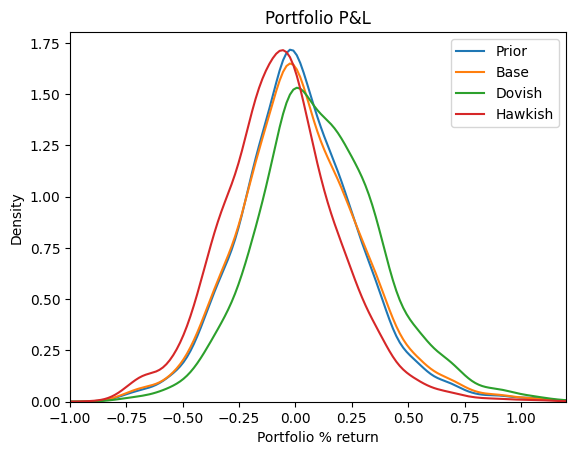

In [34]:
# Plot P&Ls
sns.kdeplot(x=pnl_pf)
sns.kdeplot(x=pnl_pf, weights=q_base)
sns.kdeplot(x=pnl_pf, weights=q_dove)
sns.kdeplot(x=pnl_pf, weights=q_hawk)
plt.title('Portfolio P&L')
plt.legend(['Prior', 'Base', 'Dovish', 'Hawkish'])
plt.xlabel('Portfolio % return')
plt.xlim([-1, 1.2])
plt.show()

# License

In [24]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2023 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.